# Building an AI-powered multimodal RAG system with Docling and Granite

*Using IBM Granite vision, text-based embeddings and generative AI models*

## Multimodal retrieval-augmented generation

[Retrieval-augmented generation (RAG)](https://www.ibm.com/think/topics/retrieval-augmented-generation) is a technique used with large language models (LLMs) to connect the model with a knowledge base of information outside the data the LLM has been trained on without having to perform [fine-tuning](https://www.ibm.com/think/topics/rag-vs-fine-tuning). Traditional RAG is limited to text-based use cases such as text summarization and chatbots.

Multimodal RAG can use [multimodal](https://www.ibm.com/think/topics/multimodal-ai) LLMs (MLLM) to process information from multiple types of data to be included as part of the external knowledge base used in RAG. Multimodal data can include text, images, audio, video or other forms. Popular multimodal LLMs include Google’s Gemini, Meta’s Llama 3.2 and OpenAI’s GPT-4 and GPT-4o.

For this recipe, you will use an IBM Granite model capable of processing different modalities. You will create an AI system to answer real-time user queries from unstructured data in a PDF.

## Recipe overview

Welcome to this Granite recipe. In this recipe, you'll learn how to harness the power of advanced tools to build an AI-powered multimodal RAG pipeline. This tutorial will guide you through the following processes:

- **Document preprocessing:** Learn how to handle documents from various sources, parse and transform them into usable formats and store them in vector databases by using Docling. You will use a Granite MLLM to generate image descriptions of images in the documents.
- **RAG:** Understand how to connect LLMs such as Granite with external knowledge bases to enhance query responses and generate valuable insights.
- **LangChain for workflow integration:** Discover how to use LangChain to streamline and orchestrate document processing and retrieval workflows, enabling seamless interaction between different components of the system.

This recipe uses three cutting-edge technologies:

1. **[Docling](https://docling-project.github.io/docling/):** An open-source toolkit used to parse and convert documents.
2. **[Granite](https://www.ibm.com/granite/docs/models/granite/):** A state-of-the-art LLM that provides robust natural language capabilities and a vision language model that provides image to text generation.
3. **[LangChain](https://github.com/langchain-ai/langchain):** A powerful framework used to build applications powered by language models, designed to simplify complex workflows and integrate external tools seamlessly.

By the end of this recipe, you will accomplish the following:
- Gain proficiency in document preprocessing, chunking and image understanding.
- Integrate vector databases to enhance retrieval capabilities.
- Use RAG to perform efficient and accurate data retrieval for real-world applications.

This recipe is designed for AI developers, researchers and enthusiasts looking to enhance their knowledge of document management and advanced natural language processing (NLP) techniques.


## Prerequisites

- Familiarity with Python programming.
- Basic understanding of LLMs, NLP concepts and computer vision.

## Step 1: Setting up the environment

Install dependencies.

In [1]:
! echo "::group::Install Dependencies"
%pip install uv
! uv pip install git+https://github.com/ibm-granite-community/utils.git \
    transformers \
    pillow \
    langchain_classic \
    langchain_core \
    langchain_huggingface sentence_transformers \
    langchain_milvus 'pymilvus[milvus_lite]' \
    docling \
    'langchain_replicate @ git+https://github.com/ibm-granite-community/langchain-replicate.git'
! echo "::endgroup::"

::group::Install Dependencies
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 22.0/22.0 MB 32.1 MB/s eta 0:00:00
Using Python 3.12.12 environment at: /usr
Resolved 140 packages in 11.09s
Prepared 37 packages in 3.95s
Uninstalled 1 package in 6ms
Installed 37 packages in 311ms
 + colorlog==6.10.1
 + docling==2.64.0
 + docling-core==2.54.0
 + docling-ibm-models==3.10.3
 + docling-parse==4.7.2
 + faker==38.2.0
 + filetype==1.2.0
 + ibm-granite-community-utils==0.1.dev120 (from git+https://github.com/ibm-granite-community/utils.git@b52bcca62520ea18e5e127f854244ee9ee9b6b69)
 + jsonlines==4.0.0
 + jsonref==1.1.0
 + langchain-classic==1.0.0
 + langchain-huggingface==1.1.0
 + langchain-milvus==0.3.1
 + langchain-replicate==0.1.dev26 (from git+https://github.com/ibm-granite-community/langchain-replicate.git@200c6f94a8c3bb59afc5dda0dfd88490cd5ba952)
 + langchain-text-splitters==1.0.0
 + latex2mathml==3.78.1
 + marko==2.2.1
 + milvus-lite==2.5.1
 + mpire==2.10.2
 + polyfactory==3.1.0
 + pyclipper==1.

## Step 2: Selecting the AI models

### Logging

To see some logging information, we can configure INFO log level.

NOTE: It is okay to skip running this cell.

In [2]:
import logging

logging.basicConfig(level=logging.INFO)

### Load the Granite models

Specify the embeddings model to use for generating text embedding vectors. Here we will use one of the [Granite Embeddings models](https://huggingface.co/collections/ibm-granite/granite-embedding-models-6750b30c802c1926a35550bb)

To use a different embeddings model, replace this code cell with one from [this Embeddings Model recipe](https://github.com/ibm-granite-community/granite-kitchen/blob/main/recipes/Components/Langchain_Embeddings_Models.ipynb).

In [3]:
from langchain_huggingface import HuggingFaceEmbeddings
from transformers import AutoTokenizer

embeddings_model_path = "ibm-granite/granite-embedding-30m-english"
embeddings_model = HuggingFaceEmbeddings(
    model_name=embeddings_model_path,
)
embeddings_tokenizer = AutoTokenizer.from_pretrained(embeddings_model_path)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/54.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/683 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/60.6M [00:00<?, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/239 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/191 [00:00<?, ?B/s]

Specify the MLLM to use for image understanding. We will use the Granite vision model.

In [4]:
from ibm_granite_community.notebook_utils import get_env_var
from langchain_replicate import Replicate
from transformers import AutoProcessor

vision_model_path = "ibm-granite/granite-vision-3.3-2b"
vision_model = Replicate(
    model=vision_model_path,
    replicate_api_token=get_env_var("REPLICATE_API_TOKEN"),
    model_kwargs={
        "max_tokens": embeddings_tokenizer.max_len_single_sentence, # Set the maximum number of tokens to generate as output.
        "min_tokens": 100, # Set the minimum number of tokens to generate as output.
    },
)
vision_processor = AutoProcessor.from_pretrained(vision_model_path)

REPLICATE_API_TOKEN not found in Google Colab secrets.
Please enter your REPLICATE_API_TOKEN: ··········


processor_config.json:   0%|          | 0.00/174 [00:00<?, ?B/s]

chat_template.json: 0.00B [00:00, ?B/s]

preprocessor_config.json: 0.00B [00:00, ?B/s]

tokenizer_config.json: 0.00B [00:00, ?B/s]

vocab.json: 0.00B [00:00, ?B/s]

merges.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

added_tokens.json:   0%|          | 0.00/107 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/701 [00:00<?, ?B/s]

Specify the language model to use for the RAG generation operation. Here we use the Replicate LangChain client to connect to a Granite model from the [`ibm-granite`](https://replicate.com/ibm-granite) org on Replicate.

To get set up with Replicate, see [Getting Started with Replicate](https://github.com/ibm-granite-community/granite-kitchen/blob/main/recipes/Getting_Started/Getting_Started_with_Replicate.ipynb).

To connect to a model on a provider other than Replicate, substitute this code cell with one from the [LLM component recipe](https://github.com/ibm-granite-community/granite-kitchen/blob/main/recipes/Components/Langchain_LLMs.ipynb).

In [5]:
from langchain_replicate import ChatReplicate

model_path = "ibm-granite/granite-4.0-h-small"
model = ChatReplicate(
    model=model_path,
    replicate_api_token=get_env_var("REPLICATE_API_TOKEN"),
    model_kwargs={
        "max_tokens": 1000, # Set the maximum number of tokens to generate as output.
        "min_tokens": 100, # Set the minimum number of tokens to generate as output.
    },
)

## Step 3: Preparing the documents for the vector database

In this example, from a set of source documents, we use [Docling](https://docling-project.github.io/docling/) to convert the documents into text and images. The text is then split into chunks. The images are processed by the MLLM to generate image summaries.

### Use Docling to download the documents and convert to text and images

Docling will download the PDF documents and process them so we can obtain the text and images the documents contain. In the PDF, there are various data types, including text, tables, graphs and images.

In [6]:
from docling.document_converter import DocumentConverter, PdfFormatOption
from docling.datamodel.base_models import InputFormat
from docling.datamodel.pipeline_options import PdfPipelineOptions

pdf_pipeline_options = PdfPipelineOptions(
    do_ocr=False,
    generate_picture_images=True,
)
format_options = {
    InputFormat.PDF: PdfFormatOption(pipeline_options=pdf_pipeline_options),
}
converter = DocumentConverter(format_options=format_options)

sources = [
    "https://midwestfoodbank.org/images/AR_2020_WEB2.pdf",
]
conversions = { source: converter.convert(source=source).document for source in sources }

With the documents processed, we then further process the text elements in the documents. We chunk them into appropriate sizes for the embeddings model we are using. A list of LangChain documents are created from the text chunks.

In [7]:
from docling_core.transforms.chunker.hybrid_chunker import HybridChunker
from docling_core.types.doc.document import TableItem
from langchain_core.documents import Document

doc_id = 0
texts: list[Document] = []
for source, docling_document in conversions.items():
    for chunk in HybridChunker(tokenizer=embeddings_tokenizer).chunk(docling_document):
        items = chunk.meta.doc_items
        if len(items) == 1 and isinstance(items[0], TableItem):
            continue # we will process tables later
        refs = " ".join(map(lambda item: item.get_ref().cref, items))
        print(refs)
        text = chunk.text
        document = Document(
            page_content=text,
            metadata={
                "doc_id": (doc_id:=doc_id+1),
                "source": source,
                "ref": refs,
            },
        )
        texts.append(document)

print(f"{len(texts)} text document chunks created")

Token indices sequence length is longer than the specified maximum sequence length for this model (669 > 512). Running this sequence through the model will result in indexing errors


#/texts/1
#/texts/4 #/texts/5 #/texts/6 #/texts/7 #/texts/8 #/texts/9 #/texts/10 #/texts/11 #/texts/12 #/texts/13
#/tables/0 #/texts/16 #/texts/17 #/texts/18
#/texts/21
#/texts/23
#/texts/25
#/texts/27
#/texts/29
#/texts/31
#/texts/33
#/texts/35 #/texts/38 #/texts/39 #/texts/40 #/texts/41
#/texts/45 #/texts/46
#/texts/48 #/texts/49 #/texts/50 #/texts/51 #/texts/52 #/texts/53 #/texts/54 #/texts/55 #/texts/56 #/texts/57
#/texts/59 #/texts/60 #/texts/61 #/texts/62 #/texts/63 #/texts/64 #/texts/65
#/texts/141
#/tables/1 #/texts/145 #/texts/153
#/texts/157 #/texts/158
#/texts/160 #/texts/161 #/texts/162
#/texts/166 #/texts/167 #/texts/168 #/texts/169
#/texts/182
#/texts/184 #/texts/185 #/texts/186 #/texts/187 #/texts/188 #/texts/189 #/texts/190
#/texts/193
#/texts/195
#/texts/197
#/texts/199
#/texts/201
#/texts/203
#/texts/205
#/texts/207
#/texts/209
#/texts/211
#/texts/213
#/texts/215
#/texts/217
#/texts/225 #/texts/226 #/texts/227
#/texts/229 #/texts/230
#/texts/232
#/texts/235 #/texts/23

Next we process any tables in the documents. We convert the table data to markdown format for passing into the language model. A list of LangChain documents are created from the table's markdown renderings.

In [8]:
from docling_core.types.doc.labels import DocItemLabel

doc_id = len(texts)
tables: list[Document] = []
for source, docling_document in conversions.items():
    for table in docling_document.tables:
        if table.label in [DocItemLabel.TABLE]:
            ref = table.get_ref().cref
            print(ref)
            text = table.export_to_markdown(docling_document)
            document = Document(
                page_content=text,
                metadata={
                    "doc_id": (doc_id:=doc_id+1),
                    "source": source,
                    "ref": ref
                },
            )
            tables.append(document)


print(f"{len(tables)} table documents created")

#/tables/1
1 table documents created


Finally we process any images in the documents. Here we use the vision language model to understand the content of an image. In this example, we are interested in any textual information in the image. You might want to experiment with different prompt text to see how it might improve the results.

NOTE: Processing the images can take a very long time depending upon the number of images and the service running the vision language model.

In [13]:
import base64
import io
import PIL.Image
import PIL.ImageOps
from ibm_granite_community.langchain.prompts import TokenizerChatPromptTemplate
from langchain_core.messages import HumanMessage
from replicate.exceptions import ReplicateError # Corrected import for ReplicateError
import time # Import time module

def encode_image(image: PIL.Image.Image, format: str = "png") -> str:
    image = PIL.ImageOps.exif_transpose(image) or image
    image = image.convert("RGB")

    buffer = io.BytesIO()
    image.save(buffer, format)
    encoding = base64.b64encode(buffer.getvalue()).decode("utf-8")
    uri = f"data:image/{format};base64,{encoding}"
    return uri

# Feel free to experiment with this prompt
image_prompt = "If the image contains text, explain the text in the image."
vision_prompt_template = TokenizerChatPromptTemplate.from_messages(
    messages=[
        HumanMessage(content=[
            {"type": "image"},
            {"type": "text", "text": image_prompt},
        ]),
    ],
    tokenizer=vision_processor)
vision_prompt = vision_prompt_template.format_prompt()

pictures: list[Document] = []
doc_id = len(texts) + len(tables)
for source, docling_document in conversions.items():
    for picture in docling_document.pictures:
        ref = picture.get_ref().cref
        print(ref)
        image = picture.get_image(docling_document)
        if image:
            # Add retry logic with exponential backoff for robustness
            max_retries = 3
            initial_delay = 5 # seconds
            for attempt in range(max_retries):
                try:
                    text = vision_model.invoke(vision_prompt, images=[encode_image(image)])
                    break # If successful, break the retry loop
                except ReplicateError as e:
                    if e.status == 429: # Rate limit error
                        print(f"Rate limit hit for image {ref}. Retrying in {initial_delay * (2**attempt)} seconds...")
                        time.sleep(initial_delay * (2**attempt))
                    else:
                        raise # Re-raise other ReplicateErrors
            else: # This block is executed if the loop completes without a 'break' (i.e., all retries failed)
                print(f"Failed to process image {ref} after {max_retries} attempts due to rate limiting.")
                text = f"Image processing failed due to repeated rate limiting for image {ref}." # Placeholder text

            document = Document(
                page_content=text,
                metadata={
                    "doc_id": (doc_id:=doc_id+1),
                    "source": source,
                    "ref": ref,
                },
            )
            pictures.append(document)

print(f"{len(pictures)} image descriptions created")

#/pictures/0
#/pictures/1
Rate limit hit for image #/pictures/1. Retrying in 5 seconds...
Rate limit hit for image #/pictures/1. Retrying in 10 seconds...
#/pictures/2
Rate limit hit for image #/pictures/2. Retrying in 5 seconds...
Rate limit hit for image #/pictures/2. Retrying in 10 seconds...
#/pictures/3
Rate limit hit for image #/pictures/3. Retrying in 5 seconds...
Rate limit hit for image #/pictures/3. Retrying in 10 seconds...
#/pictures/4
Rate limit hit for image #/pictures/4. Retrying in 5 seconds...
Rate limit hit for image #/pictures/4. Retrying in 10 seconds...
#/pictures/5
Rate limit hit for image #/pictures/5. Retrying in 5 seconds...
Rate limit hit for image #/pictures/5. Retrying in 10 seconds...
#/pictures/6
Rate limit hit for image #/pictures/6. Retrying in 5 seconds...
Rate limit hit for image #/pictures/6. Retrying in 10 seconds...
#/pictures/7
Rate limit hit for image #/pictures/7. Retrying in 5 seconds...
Rate limit hit for image #/pictures/7. Retrying in 10 seco

We can then display the LangChain documents created from the input documents.

Document ID: 1
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
bridging the gap between poverty and prosperity
Document ID: 2
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
No one could have predicted the events of 2020. The global COVID-19 pandemic created a dynamic year. With the help of volunteers, donors, staff, and most importantly, the blessings of God, Midwest Food Bank responded nimbly to the changing landscape.
All  MFB  locations  remained  open  and  responsive  to  the  need  of  our nonprofit partners. We enacted safety protocols and reduced volunteer numbers  to  maintain  social  distancing  guidelines.  To  allow  partner agencies to receive food from MFB safely, we altered our distribution model.  Community,  business,  and  donor  support  funded  operations and helped with food purchases. More details on our response to the pandemic are on page 14.
Noteworthy in 2020:
- MFB distributed a record amount of food, 37% more than 

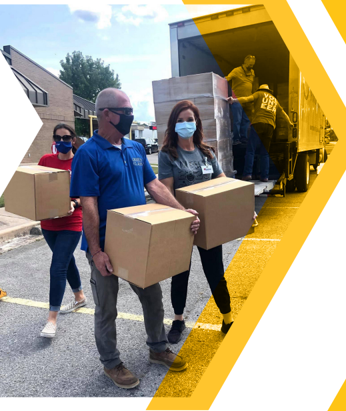

Document ID: 75
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is "Midwest Food Bank." It is a nonprofit organization that provides food to people in need. The text is designed to be clear and legible, with a strong contrast against the background, which is typical for branding and identification purposes. The use of the heart symbol in the logo is likely intended to convey the organization's commitment to caring for and helping those who are hungry. The heart is a universal symbol of love and care, which aligns with the charitable mission of the Midwest Food Bank.
Image:


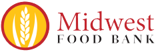

Document ID: 76
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image reads "KEEP MOVING FORWARD," which is a common phrase used to encourage persistence and progress, especially in the context of personal development or business. It suggests that one should continue to strive and advance towards their goals, regardless of any challenges or obstacles that may arise. This message is typically used in motivational contexts to inspire individuals to remain optimistic and committed to their objectives. The text is presented in a clear, bold, and impactful manner, making it immediately noticeable and memorable.
Image:


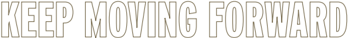

Document ID: 77
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The image contains no visible text. It is a professional headshot of a man, likely intended for corporate or promotional use. Since there is no text present, it is not possible to provide an explanation of any text within the image. If text were present, the process would involve reading and interpreting the content, which could include identifying the subject, the purpose of the text, and any relevant details it conveys. However, in this case, no text is discernible. Therefore, no further analysis of text is required.
Image:


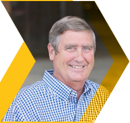

Document ID: 78
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is not fully legible due to the low resolution and the yellow filter applied to the photo. It appears to be a mix of numbers and letters, which could represent a code or a label. Without clearer text or additional context, it is not possible to accurately describe the content of the text. If the text is intended to be read, it would be helpful to have a higher resolution image or a clearer, unobstructed view to provide a precise transcription.
Image:


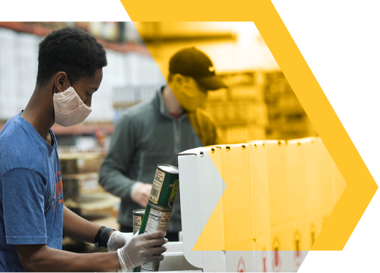

Document ID: 79
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is "GROWMARK". It is a brand name and does not contain any additional text that can be transcribed. The text is clear and legible, with no obstructions or distortions that would hinder the ability to read it. The image is simple, with a focus on the text, which is likely the subject of the image. There is no other text present that would require interpretation or expansion. The image is a straightforward branding graphic, intended to represent the "GROWMARK" brand.
Image:


Document ID: 80
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is not legible. It appears to be a placeholder commonly used in templates or mockups to indicate where text will eventually be placed. The text is not readable due to the blurriness of the image, and therefore, no meaningful content can be discerned from it. If the text is intended to convey a specific message or provide information, it cannot be accurately described without the ability to read it. In a professional setting, it is important to ensure that all images, including those used in presentations or digital content, contain clear and legible text to maintain clarity and professionalism.
Image:


Document ID: 81
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is part of the branding for the Midwest Food Bank. The text reads "Midwest Food Bank" and includes a website URL, "midwestfoodbank.org," which is intended for viewers to visit for more information about the organization. The text serves as a form of branding and is likely used to promote the organization's mission and services. It is placed in a prominent position on the image to ensure visibility and accessibility for potential donors or those seeking the services provided by the Midwest Food Bank.
Image:


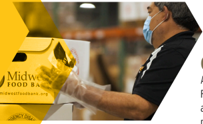

Document ID: 82
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is not legible due to its small size and the low resolution. If the text were clearer or larger, it would be possible to provide a transcription and analysis. However, with the current quality of the image, any attempt to read or interpret the text would be speculative and not reliable. If the text is intended to convey a message or provide information, it would be best to seek a higher-resolution image for accurate interpretation. In the absence of readable text, it is not possible to provide a detailed analysis of the content or message of the image.
Image:


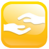

Document ID: 83
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is a representation of a person holding a book. It is not present in the actual image provided. However, if we were to hypothetically interpret the text, it could be a slogan or a message that relates to the concept of knowledge, education, or literacy. The text is stylized in a way that suggests it is part of a brand or campaign, possibly for an educational institution, a literacy program, or a bookstore. Without the actual text, it's not possible to provide a precise interpretation.
Image:


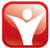

Document ID: 84
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The image contains no text. It is a simple icon that is likely used to represent a concept or action related to collaboration or teamwork, given the handshake symbol. The handshake is a universal symbol for agreement, partnership, and cooperation. In the context of digital icons, it is common to use such symbols to represent a service or feature that involves interaction between users, such as a team-based platform, a collaborative workspace, or a service that facilitates teamwork. Without additional text, it's not possible to determine the exact nature of the service or product that this icon represents.
Image:


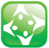

Document ID: 85
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is not legible due to the resolution and the image's low quality. It appears to be a series of characters that could be part of a larger word or phrase. Without a clearer image or additional context, it is not possible to accurately transcribe or interpret the text. If the text is intended to be read, a higher resolution image or a clearer, more detailed image would be required for proper analysis. If the text is part of a puzzle or game, it might be a clue or a hint that requires more information to solve.
Image:


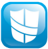

Document ID: 86
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is not discernible from the provided image. The image is a graphic representation and does not contain any readable text. If there is text present, it is not legible in the current image. If you have a specific text you would like to be identified, please provide it, and I will assist you accordingly. If the text is integral to the image's purpose or message, it might be helpful to provide additional context or details about the image so that I can give a more accurate analysis.
Image:


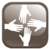

Document ID: 87
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is not entirely legible due to the low resolution and the overlapping elements. However, it appears to be a form of text that might be used for instructions or labels on the boxes. Since the text is not clear, I cannot provide a precise transcription or interpretation of the text. If the text is important, it would be best to obtain a clearer image or a higher resolution version for accurate text extraction. If the image is intended for a specific purpose, such as a label or instructional material, the text would typically include details like the contents of the box, handling instructions, or information about the contents for safety and logistical reasons.
Image:


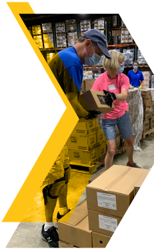

Document ID: 88
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is "FOOD INSECURITY". It is likely referring to the issue of not having access to enough nutritious food for an active and healthy life. Food insecurity can be acute, meaning it is a short-term issue, or chronic, meaning it is a persistent problem. This term is often used in discussions about public health, nutrition, and food aid. The text does not provide any additional context or data, so it is not possible to determine the source of the image or the specific message it is intended to convey beyond the general definition of food insecurity.
Image:


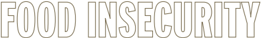

Document ID: 89
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is partially obscured and only the letters "Yea" and "pa" are visible. Without the full context or additional text, it is impossible to determine the exact meaning or content of the text. It could be part of a larger message, a slogan, or a title, but without further information, any attempt to interpret or explain the text would be speculative. If this text is from a specific source, such as a book, a website, or a piece of art, it would be most appropriate to seek out that source for accurate information.
Image:


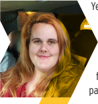

Document ID: 90
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image appears to be partially obscured, but it seems to read "ban pan Hope," which could be part of a larger message or slogan. Without the full context, it is difficult to provide a precise interpretation. However, the visible portion of the text suggests that it may be related to a campaign or event, possibly aiming to convey a message of hope. The text is placed in a way that it is not the main focus of the image but is included in the design, perhaps to complement the imagery and add a layer of meaning.
Image:


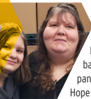

Document ID: 91
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image appears to be "FB," which could be an abbreviation for "Facebook," a social media platform. This is inferred from the common use of the acronym "FB" in online contexts. The text is partially obscured by the yellow graphic, but the visible portion of "FB" is consistent with the style of the Facebook logo. Without additional context, it is not possible to determine the full text or its intended message beyond this initial interpretation. The image may be part of a larger campaign or message related to the Facebook platform, possibly promoting a product, service, or event.
Image:


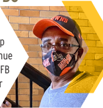

Document ID: 92
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image reads "BERLINDA a bout da," which seems to be a fragment of a sentence. Without additional context, it's challenging to provide a precise interpretation. The text could be part of a larger message or could be a quote or statement. The incomplete nature of the text prevents a definitive explanation. If this text is from a book, article, or a piece of media, it might be a title or a heading, but without further information, the exact meaning remains ambiguous.
Image:


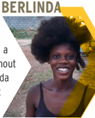

Document ID: 93
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is a representation of the various types of donations that can be made to a non-profit organization, specifically the MFB (Médecins Sans Frontières) programs. It is a visual aid that categorizes the donations into three main types: financial, food, and volunteers. The text serves to inform potential donors about the different ways they can contribute to the cause, emphasizing the importance of each category. The image is designed to be informative and encourages viewers to engage with the organization by making a donation.
Image:


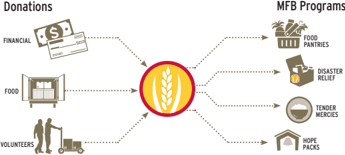

Document ID: 94
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is partially obscured, but it appears to be a caption or title for a graph that is discussing the growth in the number of Midwest Food Bank locations and the value of food distributed. The specific text is not fully visible, but it suggests that the data is related to sustainable growth in these areas. The graph itself is not fully visible, but the visible segments show an upward trend, indicating an increase in the number of locations and the value of food distributed.
Image:


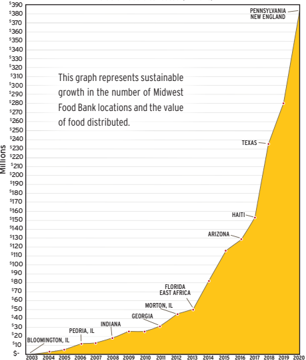

Document ID: 95
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image states that "13 MILLION SPENT YIELDS $383 MILLION FOOD DISTRIBUTED." This suggests a comparison between the cost of something and the amount of food distributed. It implies that a certain cost has been incurred and it has resulted in the distribution of $383 million worth of food. However, without additional context, it is not possible to determine the exact nature of the cost or the specifics of the food distribution.
Image:


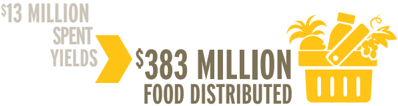

Document ID: 96
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is part of a label on the cardboard box that the person is handling. It reads "Baby Speach," which is likely a brand or product name. Due to the image resolution and the cropping of the text, it is not possible to provide the full text or its meaning. However, the text appears to be a label, which typically contains information about the product, such as its brand, product line, and possibly a slogan or tagline.
Image:


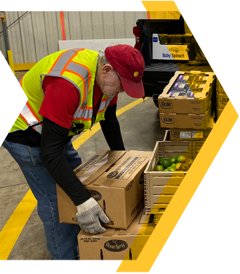

Document ID: 97
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is the logo and slogan of the Midwest Food Bank. The logo consists of a wheat stalk, which is a symbol commonly associated with agriculture and food production. The text "Midwest Food Bank" is written in a simple, bold font that is clear and legible. The slogan "Sharing the Blessings" is placed below the main text and is written in a smaller, italicized font, which adds a personal and heartfelt touch to the message. This text is intended to convey the mission and purpose of the organization, which is to provide food and nutrition to those in need within the Midwest region.
Image:


Document ID: 98
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image appears to be incomplete and only partially visible. It reads "Tende or by vo," which is not fully clear. The text seems to be part of a larger message or statement, possibly related to the event or cause the image is representing. Without the full text, it is not possible to provide a detailed interpretation of the message. If the text is intended to convey a specific message or announcement, it would be necessary to have the complete text to understand its full context and meaning.
Image:


Document ID: 99
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The image contains text that appears to be a comparison of two sets of data, likely representing some form of financial or economic metric, such as revenue or expenditure, for the years 2019 and 2020. The text is not fully legible in the image, but it seems to be structured as follows:

- For the year 2019:
  - There is a figure that could be interpreted as 5.2M, possibly representing a monetary value.
  - Below it, there is another figure that could be 1.9M or 7.2M, which might indicate a different category or a comparison.
  - The final figure for 2019 is 7.2M.

- For the year 2020:
  - The figure starts with 7.2M, which could be the same as the first year's total or a separate figure.
  - There is a smaller figure that could be 4.4M, potentially representing a different category or a comparison.
  - The final figure for 2020 is 11.6M.

The text is split into two columns, with the first column showin

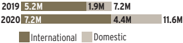

Document ID: 100
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is a part of a graphic and is not fully legible due to the resolution and the angle at which the photograph was taken. However, it appears to be a statement or slogan, possibly related to health, nutrition, or childhood. The text is in a serif font, which is often used in print media to convey a sense of formality and tradition. Without a clear view of the text, it's not possible to provide a precise interpretation of its message. If the text is meant to convey a message, it would typically be related to the image's theme of a child enjoying a healthy meal, which could be a message about the importance of nutrition for children or the joy of eating.
Image:


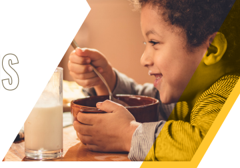

Document ID: 101
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is "A". It is a simple, stylized representation of the letter "A" in a sans-serif font. There is no additional text or imagery accompanying the letter, and it is presented against a white background which provides a high contrast for the yellow color of the text. The design is clean and modern, which may be used for various purposes such as branding, a logo, or a symbol. The text is not associated with any specific message or context within the image.
Image:


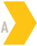

Document ID: 102
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image provides information about a remote distribution site. The text reads "Remote Distribution Sites" and is accompanied by a small icon of a remote access symbol, which is commonly used to represent online or remote access. This suggests that the image is likely educational or informational in nature, possibly used to inform about the location of remote distribution centers for services such as electricity or telecommunications. The specific mention of "GILBERT, AZ" indicates that the remote distribution site is located in Gilbert, Arizona.
Image:


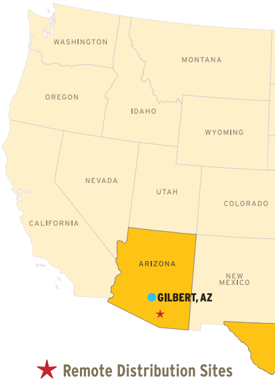

Document ID: 103
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image reads "KENYA" and "NAIROBI," which indicates that the image is a simplified map of Kenya, with a specific focus on the capital city of Kenya, Nairobi. The use of the blue dot symbolizes the city of Nairobi, which is a common way to represent cities on maps for ease of identification. The text and the dot serve as a clear indication of the geographical relationship between the text and the symbol, which is designed to be immediately recognizable to those familiar with the country and its capital.
Image:


Document ID: 104
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image refers to the "10 DOMESTIC LOCATIONS" and "2 INTERNATIONAL LOCATIONS" of the Midwest Food Bank. These locations are marked on a map of the United States, with a specific focus on the Midwest region, which includes states like Illinois, Michigan, and Ohio. The international locations are indicated with a small inset image of the globe, highlighting Haiti and Cape Verde. The text and the map together suggest that the Midwest Food Bank has a significant presence in the Midwestern United States and also has operations in Haiti and Cape Verde. The use of the term "domestic" implies that these locations are primarily within the country, while "international" indicates that the bank has a reach beyond the United States. The image serves as a visual representation of the geographical spread and international footprint of the Midwest Food Bank.
Image:


Document ID: 105
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is not legible due to the resolution and the image's content. It appears to be a mix of yellow and red, possibly part of a design or graphic intended to accompany the image of the woman. Without clearer text or additional context, it is not possible to provide a transcription or detailed analysis of the text. If the text is essential for understanding the image, it would be necessary to obtain a clearer or higher-resolution version of the image. In professional settings, it is important to avoid speculation about text that is not clearly visible or understandable.
Image:


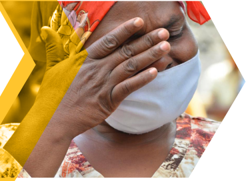

Document ID: 106
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is not clear enough to be transcribed accurately. The resolution and the image's quality do not allow for legible text. If the text is relevant to the image's context, such as a message or a slogan, it would typically be related to the cause or message being conveyed, which in this case, appears to be a charitable or community aid effort. Without clearer text, it is not possible to provide a detailed explanation of the text.
Image:


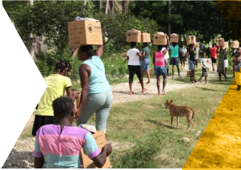

Document ID: 107
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image appears to be part of a larger message or graphic, as it is not fully visible. The visible portion of the text includes "HELP" in a bold, yellow font, which is a common color choice for attention-grabbing and urgency. The text is placed within a yellow diamond shape, which stands out against the more muted background colors. Given the context of the image, which includes individuals in military uniforms and the setting that resembles a distribution or aid center, the text likely serves to convey a message of assistance or support. However, without the full text, it is not possible to determine the complete message or its intended audience.
Image:


Document ID: 108
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is not fully legible due to the resolution and the angle of the photograph. However, it appears to be a form of informational text, possibly related to the activities of the individuals in the image, such as instructions, a company slogan, or details about the event they are participating in. Without clearer text or additional context, it is not possible to provide a precise interpretation of the text. If the text is intended to convey important information, it would typically be placed in a clear and readable format to ensure that it is accessible to all viewers, especially those who may be unable to read the text in its current form.
Image:


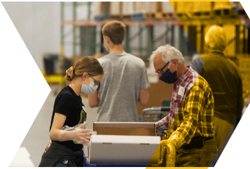

Document ID: 109
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is a statement about the ratio of volunteers to staff members in a certain organization, likely a non-profit or community-based entity, given the acronym MFB which commonly stands for "Milizia Femminile Bianca," a volunteer fire brigade in Italy. The text implies that for every staff member who is paid, there were 450 volunteers. This suggests a significant reliance on volunteer work in the organization's operations.
Image:


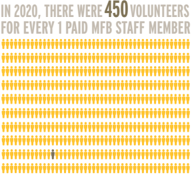

Document ID: 110
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is partially obscured and not fully legible. However, it appears to be a statement or slogan related to the Midwest Food Bank, which is a non-profit organization that provides food and other necessities to those in need. The visible text includes "Midwest Food Bank," which is a clear indication of the organization being referenced. The text on the yellow banner is not completely visible, but it seems to be a message or a slogan that is likely connected to the organization's mission or a specific campaign they are promoting. Without the full visibility of the text, it is not possible to provide a detailed transcription or interpretation of the message.
Image:


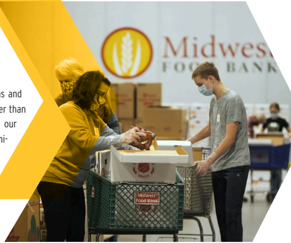

Document ID: 111
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is primarily informational, providing details about the Midwest Food Bank's disaster relief efforts. It mentions that the organization is "doing the most good," which suggests a focus on maximizing the positive impact of their aid. The text also indicates that the image is a "2020 map," which implies that the information is current as of that year. The presence of the Red Cross logo suggests that the Midwest Food Bank may be a partner or affiliate of the Red Cross in their disaster relief operations. The text is clear and legible, designed to be informative and accessible to viewers.
Image:


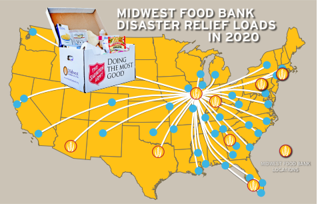

Document ID: 112
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The image contains no text. It is a graphic representation of a hand holding a smartphone with a signal strength icon. This icon is commonly used in user interfaces to indicate the strength of a mobile phone's connection to a cellular network. The signal strength icon is a standardized symbol that is universally recognized, regardless of the language or culture. It is designed to be intuitive, with the icon of the phone and the signal lines being universally understood to represent a mobile phone and its connection status.
Image:


Document ID: 113
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image reads "In addition Midwest." This text suggests that the image is part of a campaign or initiative related to Midwest, and the text implies that there is more information or additional items beyond what is shown. It is not possible to determine the full context or the nature of the text without additional information. If this text is part of a larger message, it might be intended to convey a message of support or contribution to a cause or event in the Midwest region.
Image:


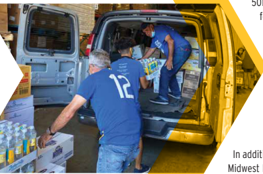

Document ID: 114
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is "MAT," which is likely an abbreviation or acronym. Without additional context, it is impossible to determine the exact meaning of "MAT." It could represent a brand, a company, an initialism, or something else. To provide a precise interpretation, one would need more information about the source of the image or the context in which it is used. If "MAT" is a known entity, its full form or meaning would be available through external sources that reference it.
Image:


Document ID: 115
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text present in the image is on the side of the semi-truck, which appears to be a form of branding or advertisement. It reads "Midwest," which is likely the name of the company or service the truck is associated with. The text is in a stylized font that is typical for commercial vehicles, designed to be readable from a distance. Without additional context or a clearer image, it is not possible to determine the full message or the industry the text is associated with.
Image:


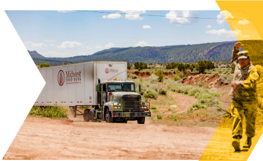

Document ID: 116
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is not legible, so I cannot provide a transcription or interpretation of it. If you have any other questions or need assistance with something else, please feel free to ask. I'm here to help! 😊

---

To ensure I'm following your guidelines, I will not attempt to make assumptions about the content of the image. If you have any specific questions or need help with a task, please provide me with the details, and I will do my best to assist you.
Image:


Document ID: 117
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is a statement that reads "MFB distributed over $52 Million." This suggests that the message is about a company or entity named MFB, which has distributed a total of $52 million. The text is designed to convey a significant financial figure in a clear and direct manner, likely for the purpose of marketing, reporting, or announcing the company's financial achievement. The use of a dollar sign and the dollar amount in the text is a standard way to represent monetary value.
Image:


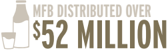

Document ID: 118
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The image contains text that is partially obscured and cut off. It appears to be discussing a comparison of percentages related to dairy, produce, and protein for the years 2019 and 2020. The visible text reads "2019 20% 2020 29%". The text seems to be indicating a change or comparison in the percentage of a certain category, possibly dairy, produce, and protein, between the years 2019 and 2020. However, without the complete text, it is not possible to determine the exact nature of the comparison or the specific category being referred to.
Image:


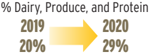

Document ID: 119
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text on the milk jugs and cartons is partially obscured and not entirely legible. However, we can make out the following text:

- "Prairie" is visible on the milk jugs.
- The text on the cartons includes "100% Pure," "1% Milk," and "Fresh."

Without a clearer image or additional context, it is not possible to provide a complete transcription of all the text present on the items. If there is a need for a precise transcription of all text on the image, a clearer image or a closer inspection would be required.
Image:


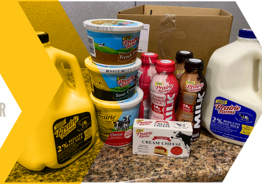

Document ID: 120
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The image contains text that appears to be a comparison of expenditures between "Comparable Organizations" and "Midwest Food Bank." The text is partially obscured, but it seems to be a title or heading for a section that is not fully visible. The text includes "Total Program Services" and "Management, General, and Fundraising Expenses," which suggests that the comparison is looking at the total program services expenditures and the percentage of these expenditures that go towards management, general, and fundraising activities. The "Midwest Food Bank" appears to be the subject of the comparison, with a bar graph showing its expenditures in millions. The text is not completely legible, so a precise interpretation of the text is not possible.
Image:


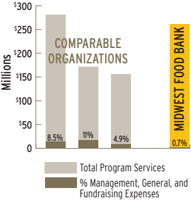

Document ID: 121
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image reads "Midwest Food Bank Share Partners." This text is likely the name of the organization and a tagline or slogan. It suggests that the image is intended to represent the Midwest Food Bank, an organization that likely focuses on food distribution and support. The presence of the tagline "Share Partners" implies a collaborative approach, possibly encouraging community involvement or partnerships in their operations. The image does not provide any specific details about the organization's activities or the services it offers.
Image:


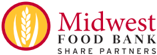

Document ID: 122
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image reads "CHARITY NAVIGATOR" at the top and "Four Star Charity" at the bottom. This text is likely a brand or organizational name, with "CHARITY NAVIGATOR" being the main title and "Four Star Charity" a tagline or a specific designation that suggests a high standard or quality within the charitable sector. The use of "Four Star" could imply a rating system or a level of excellence, with four stars being the highest. The design elements and text are meant to convey a message of trust, quality, and excellence in charitable work.
Image:


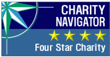

Document ID: 123
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text present in the image is "midw," which appears to be a brand or company name. The text is stylized with a gradient effect, with the "midw" part in a darker shade against a lighter background, which makes it stand out. The text is not overly large or complex, which is typical for branding elements in images meant for marketing or branding purposes. It is positioned in the lower right corner of the image, which is a common location for logos and branding in graphic design.
Image:


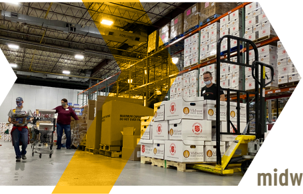

Document ID: 124
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is partially obscured, but it appears to be a statement or slogan. The visible portion reads "FOOD & DISASTER RELIEF" and "SMOKING THE ELECTRONIC CIGARETTE." This suggests that the image is likely used for a campaign or initiative related to food and disaster relief, possibly advocating against smoking electronic cigarettes. The full text is not fully legible, but it is clear that the image is meant to communicate a message about health and relief efforts.
Image:


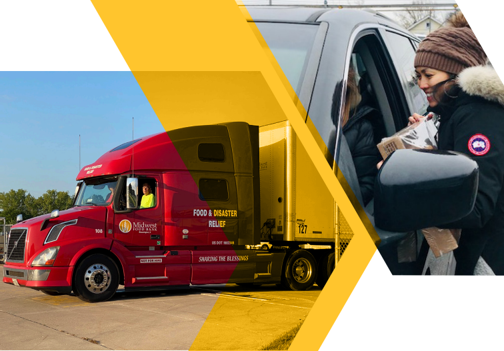

Document ID: 125
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image is on the t-shirt worn by the individual. It reads "TEAM RUBICON," which is likely the name of a team, organization, or event. Below this, there is a tagline that says "MASTER RESOURCE," which could be a slogan or a motto associated with the team or the event. The text is clear and legible, with a contrast that makes it stand out against the lighter background of the t-shirt. The text does not appear to be incomplete or obscured in any way, so it is the only text present in the image.
Image:


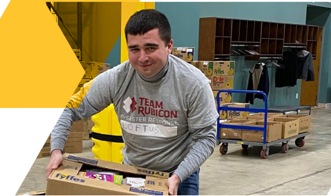

Document ID: 126
Source: https://midwestfoodbank.org/images/AR_2020_WEB2.pdf
Content:
The text in the image reads "Midwest Food Bank." It is the name of the organization, which is depicted in a clear, bold font that stands out against the background. The text is likely intended to be legible and informative, indicating that the image is a representation of the organization's branding. The text is placed in such a way that it is immediately readable and is the most prominent feature of the image. The text does not contain any additional information or context beyond the organization's name.
Image:


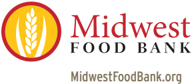

In [14]:
import itertools
from docling_core.types.doc.document import RefItem
from IPython.display import display

# Print all created documents
for document in itertools.chain(texts, tables):
    print(f"Document ID: {document.metadata['doc_id']}")
    print(f"Source: {document.metadata['source']}")
    print(f"Content:\n{document.page_content}")
    print("=" * 80)  # Separator for clarity

for document in pictures:
    print(f"Document ID: {document.metadata['doc_id']}")
    source = document.metadata['source']
    print(f"Source: {source}")
    print(f"Content:\n{document.page_content}")
    docling_document = conversions[source]
    ref = document.metadata['ref']
    picture = RefItem(cref=ref).resolve(docling_document)
    image = picture.get_image(docling_document)
    print("Image:")
    display(image)
    print("=" * 80)  # Separator for clarity


## Populate the vector database

Using the embedding model, we load the documents from the text chunks and generated image captioning into a vector database. Creating this vector database allows us to easily conduct a semantic similarity search across our documents.

NOTE: Population of the vector database can take some time depending on your embedding model and service.

### Choose your vector database

Specify the database to use for storing and retrieving embedding vectors.

To connect to a vector database other than Milvus, replace this code cell with one from [this Vector Store recipe](https://github.com/ibm-granite-community/granite-kitchen/blob/main/recipes/Components/Langchain_Vector_Stores.ipynb).

In [15]:
import tempfile
from langchain_core.vectorstores import VectorStore
from langchain_milvus import Milvus

db_file = tempfile.NamedTemporaryFile(prefix="vectorstore_", suffix=".db", delete=False).name
print(f"The vector database will be saved to {db_file}")

vector_db: VectorStore = Milvus(
    embedding_function=embeddings_model,
    connection_args={"uri": db_file},
    auto_id=True,
    enable_dynamic_field=True,
    index_params={"index_type": "AUTOINDEX"},
)

The vector database will be saved to /tmp/vectorstore_2ue3alq1.db


We now add all the LangChain documents for the text, tables and image descriptions to the vector database.

In [16]:
import itertools

documents = list(itertools.chain(texts, tables, pictures))
ids = vector_db.add_documents(documents)
print(f"{len(ids)} documents added to the vector database")

126 documents added to the vector database


## Step 4: RAG with Granite

Now that we have successfully converted our documents and vectorized them, we can set up out RAG pipeline.

### Retrieve relevant chunks



Here we test the vector database by searching for chunks with relevant information to our query in the vector space. We display the documents associated with the retrieved image description.

Feel free to try different queries.

In [17]:
query = "How much was spent on food distribution relative to the amount of food distributed?"
for doc in vector_db.as_retriever().invoke(query):
    print(doc)
    print("=" * 80)  # Separator for clarity

page_content='The text in the image states that "13 MILLION SPENT YIELDS $383 MILLION FOOD DISTRIBUTED." This suggests a comparison between the cost of something and the amount of food distributed. It implies that a certain cost has been incurred and it has resulted in the distribution of $383 million worth of food. However, without additional context, it is not possible to determine the exact nature of the cost or the specifics of the food distribution.' metadata={'pk': 462716593175789662, 'doc_id': 95, 'source': 'https://midwestfoodbank.org/images/AR_2020_WEB2.pdf', 'ref': '#/pictures/21'}
page_content='Midwest Food Bank Growth Value of food distributed (millions) Value of food distributed (millions)' metadata={'pk': 462716593175789582, 'doc_id': 15, 'source': 'https://midwestfoodbank.org/images/AR_2020_WEB2.pdf', 'ref': '#/texts/141'}
page_content='We  receive  donated  food  from  all  over  the country  -  food  produced  in  excess,  incorrect labeling,  and  more.  Donated  food

The returned document should be responsive to the query. Let's go ahead and construct our RAG pipeline.

### Create the RAG pipeline for Granite

First we create the prompts for Granite to perform the RAG query. We use the Granite chat template and supply the placeholder values that the LangChain RAG pipeline will replace.

Next, we construct the RAG pipeline by using the Granite prompt templates previously created.


In [18]:
from ibm_granite_community.langchain.chains.combine_documents import create_stuff_documents_chain
from langchain_classic.chains.retrieval import create_retrieval_chain
from langchain_core.prompts import ChatPromptTemplate

# Create a Granite prompt for question-answering with the retrieved context
prompt_template = ChatPromptTemplate.from_template("{input}")

# Assemble the retrieval-augmented generation chain
combine_docs_chain = create_stuff_documents_chain(
    llm=model,
    prompt=prompt_template,
)
rag_chain = create_retrieval_chain(
    retriever=vector_db.as_retriever(),
    combine_docs_chain=combine_docs_chain,
)

### Generate a retrieval-augmented response to a question

The pipeline uses the query to locate documents from the vector database and use them as context for the query.

In [19]:
from ibm_granite_community.notebook_utils import wrap_text

output = rag_chain.invoke({"input": query})

print(wrap_text(output['answer']))

Based on the information provided in the context, it appears that $13 million
was spent on food distribution, which yielded $383 million worth of food
distributed.

The key evidence for this is the statement in the first piece of context:

"The text in the image states that '13 MILLION SPENT YIELDS $383 MILLION FOOD
DISTRIBUTED.'"

This suggests that for every $1 million spent, $29.46 million worth of food was
distributed ($383 million / $13 million = 29.46).

The other pieces of context provide additional information about the food
distribution process, such as the sources of the donated food and the prevalence
of food insecurity in the United States. However, they do not directly address
the specific question of how much was spent relative to the amount of food
distributed.


Awesome! We have created an AI application that can successfully leverage knowledge from the source documents' text and images.

## Next Steps

- Explore advanced RAG workflows for other industries.
- Experiment with other document types and larger datasets.
- Optimize prompt engineering for better Granite responses.

Thank you for using this recipe!